# Information Retrieval and Web Analytics

# FINAL PROJECT

#Astrid Alins, Miquel Bisbe, Cinta Carot


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Necessary imports

In [2]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import re


#### Load data into memory


In [4]:
docs_path = '/content/drive/Shared drives/IRWA/FINAL PROJECT/fashion_products_dataset.json'
with open(docs_path, 'r', encoding='utf-8') as f:
    documents = json.load(f)

print(f"Number of docs: {len(documents)}")

Number of docs: 28080


###**PART 1: Text Processing and Exploratory Data Analysis**

## 1.1 Data preparation



### 1.1.1
Preprocessing of the documents
- Removing stop words
- Tokenization
- Removing punctuation marks
- Stemming
- Bonus point

In [5]:
# Initialize the stemmer and stop words set (from nltk)
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))
#Function to clean line by line:
def clean_line(text):
    # Normalize text:
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)# remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces

    # Tokenize
    tokens = text.split()

    # Remove stop words and stemming
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w) > 2]

    return tokens

In [6]:
for doc in documents:
    doc['title_tokens'] = clean_line(doc.get('title', ''))
    doc['desc_tokens'] = clean_line(doc.get('description', ''))

###1.1.2
Take into account that for future queries, the final output must return (when present) the following information for each of the selected documents: pid, title, description, brand, category, sub_category, product_details, seller, out_of_stock, selling_price, discount, actual_price, average_rating, url


In [7]:
def preprocess_document(doc):
    """
    doc és un diccionari amb tots els camps del producte
    """
    # Camps textuals
    for field in ["title", "description"]:
        if field in doc and isinstance(doc[field], str):
            doc[field] = clean_line(doc[field])

    # Els altres camps es mantenen com estan
    # (només assegura que existeixin)

    return {
        "pid": doc.get("pid"),
        "title": doc.get("title"),
        "description": doc.get("description"),
        "brand": doc.get("brand"),
        "category": doc.get("category"),
        "sub_category": doc.get("sub_category"),
        "product_details": doc.get("product_details"),
        "seller": doc.get("seller"),
        "out_of_stock": doc.get("out_of_stock"),
        "selling_price": doc.get("selling_price"),
        "discount": doc.get("discount"),
        "actual_price": doc.get("actual_price"),
        "average_rating": doc.get("average_rating"),
        "url": doc.get("url")
    }


In [8]:
# Processar una mostra petita per veure resultats
preprocessed_docs = [preprocess_document(doc) for doc in documents[:5]]

for d in preprocessed_docs:
    print(json.dumps(d, indent=2))


{
  "pid": "TKPFCZ9EA7H5FYZH",
  "title": [
    "solid",
    "women",
    "multicolor",
    "track",
    "pant"
  ],
  "description": [
    "yorker",
    "trackpant",
    "made",
    "rich",
    "comb",
    "cotton",
    "give",
    "rich",
    "look",
    "design",
    "comfort",
    "skin",
    "friendli",
    "fabric",
    "itch",
    "free",
    "waistband",
    "great",
    "year",
    "round",
    "use",
    "proudli",
    "made",
    "india"
  ],
  "brand": "York",
  "category": "Clothing and Accessories",
  "sub_category": "Bottomwear",
  "product_details": [
    {
      "Style Code": "1005COMBO2"
    },
    {
      "Closure": "Elastic"
    },
    {
      "Pockets": "Side Pockets"
    },
    {
      "Fabric": "Cotton Blend"
    },
    {
      "Pattern": "Solid"
    },
    {
      "Color": "Multicolor"
    }
  ],
  "seller": "Shyam Enterprises",
  "out_of_stock": false,
  "selling_price": "921",
  "discount": "69% off",
  "actual_price": "2,999",
  "average_rating": "3.9",
  "ur

###1.1.3
Decide how to handle the fields category, sub_category, brand, product_details, and seller during pre-processing. Should they be merged into a single text field, indexed as separate fields in the inverted index or any other alternative? Justify your choice, considering how their distinctiveness may affect retrieval effectiveness. What are pros and cons of each approach?

-  **Merging into a Single Text Field:** Concatenate the values of these fields into the main text content of the document (e.g., add them to the `description` or create a new `all_text` field).
    *   **Pros:**
        *   Simplifies the indexing process, as you only need one inverted index for the entire text.
        *   Allows for keyword searches across all fields simultaneously.
    *   **Cons:**
        *   Loses the distinctiveness of each field. A search for "Nike" would match "Nike" in the brand, but also if it appears in a product detail or description, which might not be the desired result.
        *   Difficult to perform field-specific searches (e.g., "only show me products where the brand is Nike").
        *   Might introduce noise into the index, making it harder to retrieve relevant documents based on specific attributes.

-  **Indexing as Separate Fields (Faceted Search):** Create separate indices or designate specific fields in your index for each of these fields (`category_index`, `brand_index`, etc.). This is often used in conjunction with the main text index.
    *   **Pros:**
        *   Preserves the distinctiveness of each field, allowing for precise field-specific searches (e.g., `brand:"Nike"`).
        *   Enables faceted search, where users can filter results based on categories, brands, sellers, etc., which greatly enhances user experience and retrieval effectiveness in e-commerce.
        *   Reduces noise in the main text index.
    *   **Cons:**
        *   More complex indexing and querying process compared to a single text field.
        *   Requires more storage space for multiple indices.

-  **Alternative: Combining with Textual Analysis (Hybrid Approach):** Index these fields separately for faceted search and field-specific queries, while also potentially including them in the main text field (or a separate "searchable text" field) after some processing. For `product_details`, you might parse the key-value pairs and index both the keys and values, possibly with weighting.
    *   **Pros:**
        *   Leverages the benefits of both approaches: enables faceted search and precise field-specific queries while still allowing general keyword search that can hit terms in these fields.
        *   Provides more flexibility in querying.
    *   **Cons:**
        *   Most complex to implement and manage.
        *   Requires careful consideration of how to weight terms from different fields in the main text index.

We decided to index brand, category, sub_category, and seller as separate fields, since they contain structured and highly distinctive categorical information. In contrast, product_details will be merged with the main textual fields (title and description), as it provides descriptive terms that are useful for keyword-based retrieval.

This hybrid approach allows better control over field weighting and improves retrieval effectiveness by combining precise filtering (on categorical fields) with richer semantic matching (on textual content). The main drawback is a slightly higher implementation complexity, but the gain in ranking accuracy and interpretability justifies this choice.


###1.1.4
Consider the fields out_of_stock, selling_price, discount, actual_price, and average_rating. Decide how these should be handled during pre-processing to use in further search. Should they be indexed as textual terms?

Indexing these fields as textual terms would generally not be the most effective approach. This is because:

*   **Numerical/Boolean Nature**: These fields are primarily numerical (selling_price, discount, actual_price, average_rating) or boolean (out_of_stock). Textual indexing is designed for free text search, not for numerical comparisons or filtering based on true/false values.
*   **Loss of Structure and Meaning**: Treating these as text would lose their inherent structure and meaning. You wouldn't be able to easily perform range queries (e.g., products under $50), sort by price, or filter by availability.
*   **Ineffective for Filtering/Sorting**: Users typically want to filter search results based on price range, availability, or sort by rating. Textual indexing doesn't support these operations efficiently or accurately.


To be handled, these fields should be indexed as their native data types and used for filtering, sorting, and potentially range queries:

*   **`out_of_stock`**: This is a boolean field. It should be indexed as a boolean (True/False). This allows users to easily filter for items that are in stock.
*   **`selling_price`**, **`actual_price`**: These are numerical values. They should be converted to a numerical data type (e.g., float or integer) and indexed as such. This enables:
    *   **Range Queries**: Finding products within a specific price range (e.g., $10 - $50).
    *   **Sorting**: Sorting results by price (lowest to highest or highest to lowest).
    *  **Filtering**: Filtering by maximum or minimum price.
Note: You might need to clean the price strings (remove currency symbols, commas) before converting them to numbers.
*   **`discount`**: This is likely a percentage string (e.g., "69% off"). You could extract the numerical percentage and index it as a number to enable sorting by discount amount or filtering for products with a minimum discount.
*   **`average_rating`**: This is a numerical value (often a float). It should be indexed as a number to allow:
    *   **Filtering**: Showing products above a certain rating (e.g., 4.0 and above).
    *   **Sorting**: Sorting results by average rating (highest to lowest).

In summary, these fields are best handled as structured data (boolean or numerical) for effective filtering, sorting, and range queries, rather than being indexed as unstructured text. This aligns with how users typically interact with these types of attributes on e-commerce websites.

# PART 1.2: Exploratory Data Analysis

In [9]:
# =========================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from itertools import chain

# Convert documents to DataFrame
df = pd.DataFrame(documents)

# -------------------------------
# Data cleaning helper functions
# -------------------------------
def to_float(x):
    """Convert string with symbols or empty to float, if possible."""
    if pd.isna(x):
        return np.nan
    x = re.sub(r'[^0-9.]', '', str(x))
    return float(x) if x else np.nan

def to_discount(x):
    """Extract numeric percentage from discount string."""
    if pd.isna(x):
        return np.nan
    x = re.sub(r'[^0-9.]', '', str(x))
    return float(x) if x else np.nan

# -------------------------------
# Convert fields to numeric types
# -------------------------------
df["selling_price"] = df["selling_price"].apply(to_float)
df["actual_price"] = df["actual_price"].apply(to_float)
df["discount"] = df["discount"].apply(to_discount)
df["average_rating"] = pd.to_numeric(df["average_rating"], errors='coerce')
df["out_of_stock"] = df["out_of_stock"].astype(bool)

# -------------------------------
# Add text statistics
# -------------------------------
df["title_len"] = df["title_tokens"].apply(len)
df["desc_len"] = df["desc_tokens"].apply(len)

df[["selling_price", "actual_price", "discount", "average_rating"]].describe()


,selling_price,actual_price,discount,average_rating
count,28078.000000,27303.000000,27225.000000,25819.000000
mean,705.635088,1455.528110,50.256896,3.627724
std,549.681489,939.977456,16.887287,0.663429
min,99.000000,150.000000,1.000000,1.000000
25%,390.000000,849.000000,40.000000,3.200000
50%,545.000000,1199.000000,53.000000,3.800000
75%,820.000000,1799.000000,63.000000,4.100000
max,7999.000000,12999.000000,87.000000,5.000000


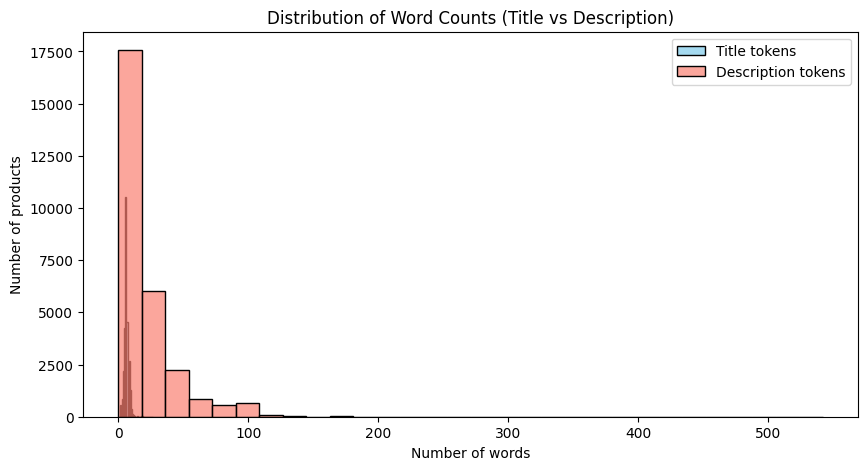

Total unique words in dataset: 4536
Average unique words per description: 15.30


/tmp/ipython-input-4096135227.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rated, x="average_rating", y="title", palette="viridis")


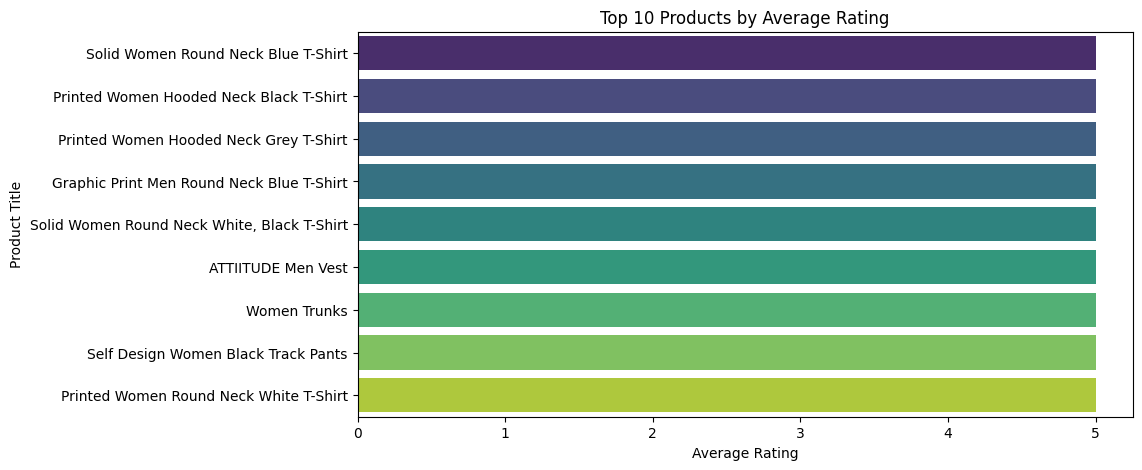

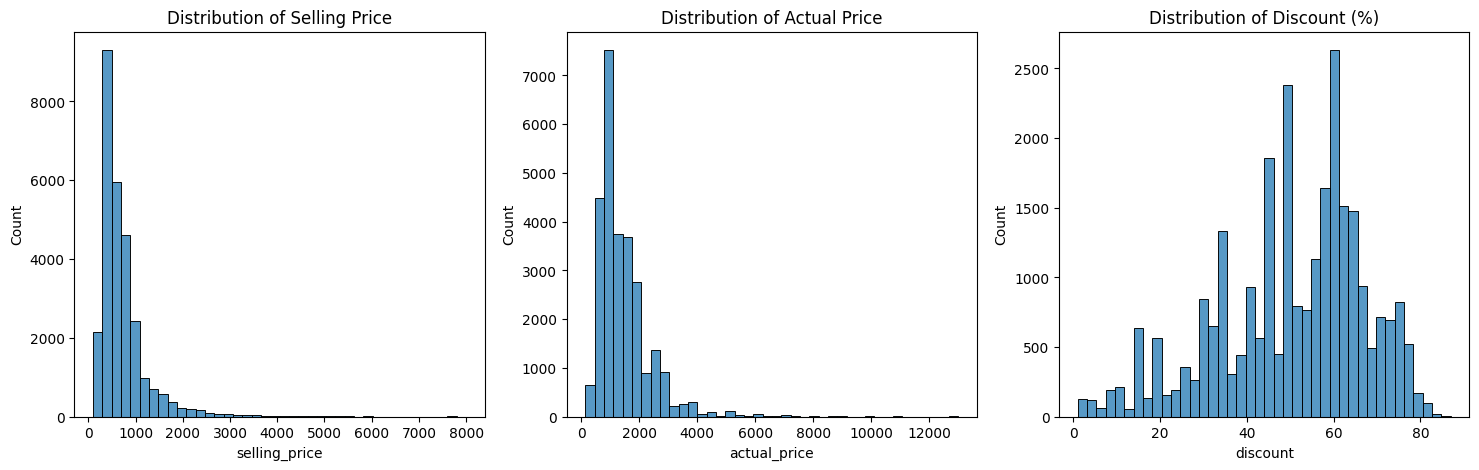

/tmp/ipython-input-4096135227.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, ax=axes[0], palette="Blues_d")
/tmp/ipython-input-4096135227.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sellers.values, y=top_sellers.index, ax=axes[1], palette="Greens_d")


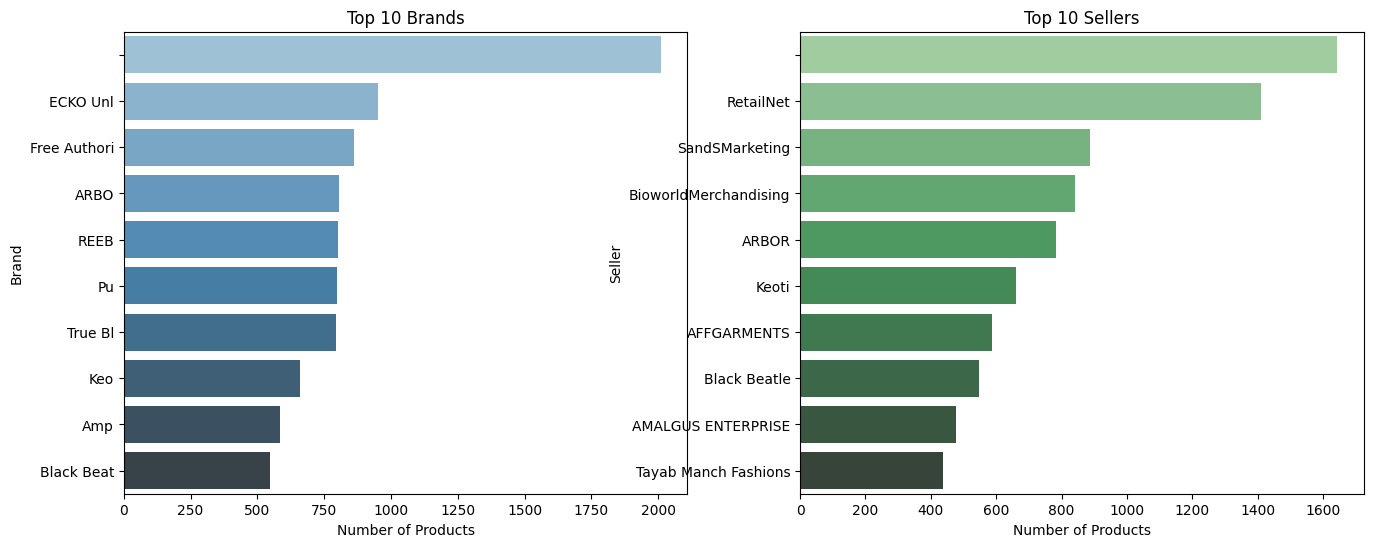

/tmp/ipython-input-4096135227.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=out_stock_counts.index.map({True: 'Out of Stock', False: 'Available'}),


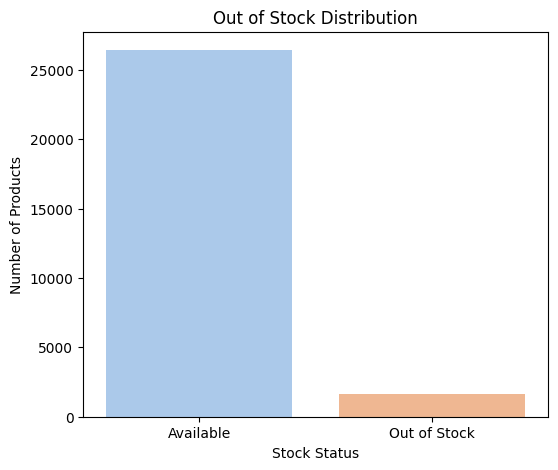

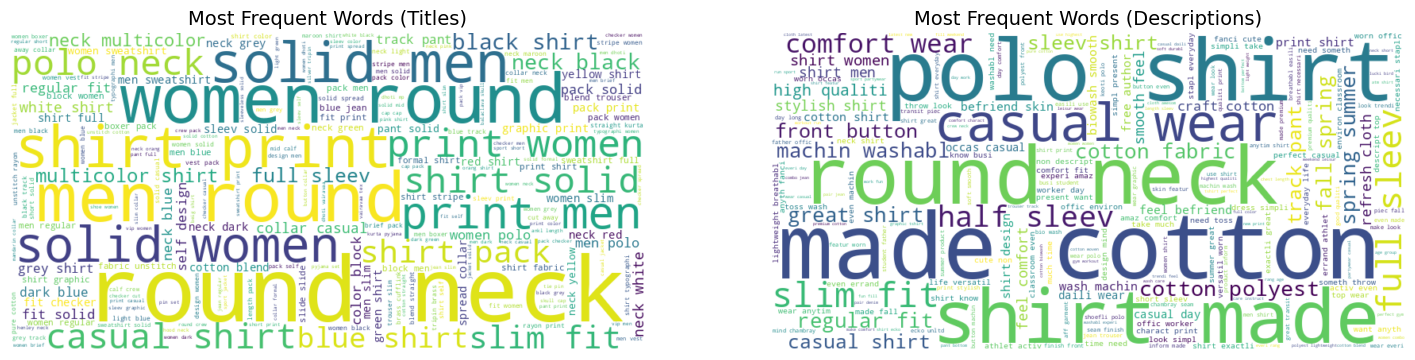

8.94% of products mention a color.


In [10]:

# -------------------------------
# 1. Word count distributions
# -------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["title_len"], bins=30, color='skyblue', label='Title tokens')
sns.histplot(df["desc_len"], bins=30, color='salmon', label='Description tokens', alpha=0.7)
plt.legend()
plt.title("Distribution of Word Counts (Title vs Description)")
plt.xlabel("Number of words")
plt.ylabel("Number of products")
plt.show()

# -------------------------------
# 2. Vocabulary statistics
# -------------------------------
all_words = list(chain.from_iterable(df["title_tokens"])) + list(chain.from_iterable(df["desc_tokens"]))
vocab = set(all_words)
print(f"Total unique words in dataset: {len(vocab)}")

df["unique_words"] = df["desc_tokens"].apply(lambda x: len(set(x)))
print(f"Average unique words per description: {df['unique_words'].mean():.2f}")

# -------------------------------
# 3. Top-rated products
# -------------------------------
top_rated = df.sort_values(by="average_rating", ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(data=top_rated, x="average_rating", y="title", palette="viridis")
plt.title("Top 10 Products by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Product Title")
plt.show()

# -------------------------------
# 4. Price and discount distributions
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df["selling_price"], bins=40, ax=axes[0])
axes[0].set_title("Distribution of Selling Price")
sns.histplot(df["actual_price"], bins=40, ax=axes[1])
axes[1].set_title("Distribution of Actual Price")
sns.histplot(df["discount"], bins=40, ax=axes[2])
axes[2].set_title("Distribution of Discount (%)")
plt.show()

# -------------------------------
# 5. Top brands and sellers
# -------------------------------
top_brands = df["brand"].value_counts().head(10)
top_sellers = df["seller"].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x=top_brands.values, y=top_brands.index, ax=axes[0], palette="Blues_d")
axes[0].set_title("Top 10 Brands")
axes[0].set_xlabel("Number of Products")
axes[0].set_ylabel("Brand")

sns.barplot(x=top_sellers.values, y=top_sellers.index, ax=axes[1], palette="Greens_d")
axes[1].set_title("Top 10 Sellers")
axes[1].set_xlabel("Number of Products")
axes[1].set_ylabel("Seller")
plt.show()

# -------------------------------
# 6. Out of stock distribution
# -------------------------------
out_stock_counts = df["out_of_stock"].value_counts()
plt.figure(figsize=(6,5))
sns.barplot(x=out_stock_counts.index.map({True: 'Out of Stock', False: 'Available'}),
            y=out_stock_counts.values, palette="pastel")
plt.title("Out of Stock Distribution")
plt.xlabel("Stock Status")
plt.ylabel("Number of Products")
plt.show()

# -------------------------------
# 7. Word clouds
# -------------------------------
title_text = ' '.join([' '.join(t) for t in df["title_tokens"]])
desc_text = ' '.join([' '.join(t) for t in df["desc_tokens"]])

fig, ax = plt.subplots(1, 2, figsize=(18,8))
wc_title = WordCloud(width=800, height=400, background_color='white').generate(title_text)
wc_desc = WordCloud(width=800, height=400, background_color='white').generate(desc_text)

ax[0].imshow(wc_title, interpolation='bilinear')
ax[0].set_title("Most Frequent Words (Titles)", fontsize=14)
ax[0].axis('off')
ax[1].imshow(wc_desc, interpolation='bilinear')
ax[1].set_title("Most Frequent Words (Descriptions)", fontsize=14)
ax[1].axis('off')
plt.show()

# -------------------------------
# 8. Optional: Detect colors mentioned
# -------------------------------
color_words = ["red","blue","green","black","white","grey","brown","pink","yellow","multicolor"]
df["has_color"] = df["desc_tokens"].apply(lambda tokens: any(c in tokens for c in color_words))
print(f"{df['has_color'].mean()*100:.2f}% of products mention a color.")


### **PART 2: Indexing and Evaluation**

### 2.1 INDEXING

###2.1.1:
Build inverted index: After having pre-processed the data, you can then create the inverted index.

***HINT*** - you may use the vocabulary data structure, like the one seen during the
Practical Labs:
{
Term_id_1: [document_1, document_2, document_4],
Term_id_2: [document_1, document_3, document_5, document_6],
etc...
}

In [11]:
# We will use pid as the document ID, and combine title and description for the text.
def create_inverted_index(documents):
    """
    Implement the inverted index using the preprocessed documents.

    Argument:
    documents -- list of dictionaries, where each dictionary is a preprocessed document

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    doc_id_to_info - a dictionary to map document IDs to relevant information (pid, title, etc.)
    """
    index = defaultdict(list)
    doc_id_to_info = {}
    # Assign a unique integer ID to each document for the index
    for doc_id, doc in enumerate(documents):
        pid = doc.get("pid")
        title_tokens = doc.get("title_tokens", [])
        desc_tokens = doc.get("desc_tokens", [])

        if pid is None:
            continue # Skip documents without a PID

        doc_id_to_info[doc_id] = {
            "pid": pid,
            "title": doc.get("title", []),
            "description": doc.get("description", []),
            "brand": doc.get("brand"),
            "category": doc.get("category"),
            "sub_category": doc.get("sub_category"),
            "product_details": doc.get("product_details"),
            "seller": doc.get("seller"),
            "out_of_stock": doc.get("out_of_stock"),
            "selling_price": doc.get("selling_price"),
            "discount": doc.get("discount"),
            "actual_price": doc.get("actual_price"),
            "average_rating": doc.get("average_rating"),
            "url": doc.get("url")
        }


        # Combine title and description tokens for indexing
        all_tokens = title_tokens + desc_tokens

        current_doc_index = {}
        for position, term in enumerate(all_tokens):
            if term not in current_doc_index:
                current_doc_index[term] = [doc_id, array('I', [position])]
            else:
                current_doc_index[term][1].append(position)

        # Merge the current document index with the main index
        for term, posting in current_doc_index.items():
            index[term].append(posting)

    return index, doc_id_to_info

In [12]:
# Build the inverted index using the preprocessed documents
inverted_index, doc_info = create_inverted_index(documents)

print(f"Inverted index created with {len(inverted_index)} unique terms.")

Inverted index created with 4536 unique terms.


###2.1.2


Propose test queries: Define five queries that will be used to evaluate your search engine. (Be creative)

***HINT*** - How to choose the queries? The selection of the queries is up to you, but it’s suggested to select terms based on the popularity (keywords ranked by term frequencies or by TF-IDF, etc).

The chosen 5 queries are:
* women black dress
* men casual shirt cotton
* solid color track pant
* print t shirt
* blue jeans slim fit

The five test queries were formulated based on insights from the Exploratory Data Analysis (EDA), particularly the word clouds generated from product titles and descriptions. By observing the most frequent and bigger terms in these visualizations, we identified common keywords and phrases that users are likely to search for. The selected queries combine these popular terms to represent realistic scenarios within the dataset.

###2.1.3


Rank your results: Implement the TF-IDF algorithm and provide ranking-based results.

In [13]:
import math
from collections import defaultdict

def rank_query_tf_idf(query, inverted_index, doc_info):
    """
    Rank documents for a query using TF-IDF.

    Args:
        query (str): user query
        inverted_index (dict): term -> list of [doc_id, positions]
        doc_info (dict): doc_id -> metadata

    Returns:
        ranked_docs (list of tuples): (doc_id, score), sorted descending
    """
    N = len(doc_info)
    query_terms = query.lower().split()

    # Compute DF and IDF
    df = {term: len(inverted_index.get(term, [])) for term in query_terms}
    idf = {term: math.log(N / df[term]) if df[term] > 0 else 0 for term in query_terms}

    # Compute TF-IDF per document
    doc_scores = defaultdict(float)
    for term in query_terms:
        postings = inverted_index.get(term, [])
        for posting in postings:
            doc_id, positions = posting[0], posting[1]
            tf = len(positions)
            doc_scores[doc_id] += tf * idf[term]

    # Sort documents by score descending
    ranked_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_docs

# Example usage
test_queries = [
    "women black dress",
    "men casual shirt cotton",
    "solid color track pant",
    "print t shirt",
    "blue jeans slim fit"
]

for q in test_queries:
    ranked = rank_query_tf_idf(q, inverted_index, doc_info)
    print(f"Query: '{q}'")
    for doc_id, score in ranked[:5]:  # top 5 results
        print(f"  Doc {doc_info[doc_id]['title']} - Score: {score:.4f}")
    print()


Query: 'women black dress'
  Doc Solid Women V Neck Maroon T-Shirt - Score: 82.8949
  Doc Color Block Men V Neck Dark Blue T-Shirt - Score: 67.4185
  Doc Checkered Women Denim Black Cargo Shorts - Score: 10.6189
  Doc Checkered Men Denim Black Cargo Shorts - Score: 9.8820
  Doc Printed Men Denim Black Cargo Shorts - Score: 9.8820

Query: 'men casual shirt cotton'
  Doc Color Block Men V Neck Dark Blue T-Shirt - Score: 60.3764
  Doc Solid Women V Neck Maroon T-Shirt - Score: 44.4051
  Doc Printed Men Round Neck Grey T-Shirt - Score: 32.2669
  Doc Mps Solid Men Dhoti - Score: 26.3168
  Doc Graphic Print Men Round Neck Blue T-Shirt - Score: 17.6450

Query: 'solid color track pant'
  Doc Solid Men Blue Track Pants - Score: 41.4185
  Doc Solid Women Brown Track Pants - Score: 41.4185
  Doc Solid Women Grey Track Pants - Score: 41.4185
  Doc Solid Women Black Track Pants - Score: 41.4185
  Doc Solid Men White Track Pants - Score: 37.7197

Query: 'print t shirt'
  Doc Solid Women V Neck Maroo

### 2.2 EVALUATION


###2.2.1

Implement the following evaluation metrics to assess the effectiveness of your retrieval solutions. These metrics will help you measure how well your system retrieves relevant documents for each query:

i. Precision@K (P@K)

ii. Recall@K (R@K)

iii. Average Precision@K (P@K)

iv. F1-Score@K

v. Mean Average Precision (MAP)

vi. Mean Reciprocal Rank (MRR)

vii. Normalized Discounted Cumulative Gain (NDCG)

In [14]:
import math

#i. Precision@K (P@K)
def precision_at_k(ranked_list, relevance, K):
    top_k = ranked_list[:K]
    # Safely get relevance, assume 0 if not in dict
    relevant = sum([relevance.get(doc, 0) for doc in top_k])
    return relevant / K if K > 0 else 0

#ii. Recall@K (R@K)
def recall_at_k(ranked_list, relevance, K):
    top_k = ranked_list[:K]
    # Safely get relevance, assume 0 if not in dict
    relevant_in_top_k = sum([relevance.get(doc, 0) for doc in top_k])
    total_relevant = sum(relevance.values())
    return relevant_in_top_k / total_relevant if total_relevant > 0 else 0

#iii. Average Precision@K (P@K)
def average_precision(ranked_list, relevance, K):
    ap = 0
    num_relevant = 0
    for i, doc in enumerate(ranked_list[:K], start=1):
        # Safely get relevance, assume 0 if not in dict
        if relevance.get(doc, 0) == 1:
            num_relevant += 1
            ap += num_relevant / i
    total_relevant = sum(relevance.values())
    return ap / total_relevant if total_relevant > 0 else 0

#iv. F1-Score@K
def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#v. Mean Average Precision (MAP)
def mean_average_precision(all_ranked_lists, all_relevance, K):
    ap_sum = 0
    Q = len(all_ranked_lists)
    for qid in all_ranked_lists:
        ap_sum += average_precision(all_ranked_lists[qid], all_relevance[qid], K)
    return ap_sum / Q if Q > 0 else 0

#vi. Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(all_ranked_lists, all_relevance):
    rr_sum = 0
    Q = len(all_ranked_lists)
    for qid in all_ranked_lists:
        for i, doc in enumerate(all_ranked_lists[qid], start=1):
            # Safely get relevance, assume 0 if not in dict
            if all_relevance[qid].get(doc, 0) == 1:
                rr_sum += 1 / i
                break
    return rr_sum / Q if Q > 0 else 0

#vii. Normalized Discounted Cumulative Gain (NDCG)
def ndcg_at_k(ranked_list, relevance, K):
    dcg = 0
    for i, doc in enumerate(ranked_list[:K], start=1):
        # Safely get relevance, assume 0 if not in dict
        rel = relevance.get(doc, 0)
        dcg += (2**rel - 1) / math.log2(i + 1)
    # Ideal DCG
    sorted_rels = sorted(relevance.values(), reverse=True)
    idcg = sum((2**rel - 1)/math.log2(i+1) for i, rel in enumerate(sorted_rels[:K], start=1))
    return dcg / idcg if idcg > 0 else 0

###2.2.2

Apply the evaluation metrics you have implemented to the search results and relevance judgments provided in validation_labels.csv for the predefined queries. When reporting evaluation results, provide only numeric values, rounded to three decimal places. Do not include textual explanations or additional statistics in this section.

a. Query 1: women full sleeve sweatshirt cotton

b. Query 2: men slim jeans blue

In [15]:
# Load the 'validation_labels.csv'
labels_path = '/content/drive/Shared drives/IRWA/FINAL PROJECT/validation_labels.csv'
validation_labels_df = pd.read_csv(labels_path)

# Convert the labels into a dictionary--> query_text: {doc_id: relevance}
relevance_total = defaultdict(dict)
for index, row in validation_labels_df.iterrows():
    # Taking into account that the csv doc has the coumns: 'query_id', 'pid', and 'labels'
    query_id = row['query_id']
    pid = row['pid']
    relevance = row['labels']

    # Find the doc_id corresponding to the PID
    doc_id = None
    for d_id, info in doc_info.items():
        if info['pid'] == pid:
            doc_id = d_id
            break

    if doc_id is not None:
        # Map query IDs to actual query strings
        query_map = {
            1: "women full sleeve sweatshirt cotton",
            2: "men slim jeans blue"
        }
        query = query_map.get(query_id)
        if query:
            relevance_total[query][doc_id] = relevance


# Our queries to evaluate
queries_to_evaluate = [
    "women full sleeve sweatshirt cotton",
    "men slim jeans blue"
]

K = 10 #cutoff value K
all_ranked_lists = {}

# Calculate and print metrics for each query
for query in queries_to_evaluate:
    # Retrieve ranked documents using TF-IDF
    ranked_list_with_scores = rank_query_tf_idf(query, inverted_index, doc_info)
    ranked_list = [doc_id for doc_id, score in ranked_list_with_scores]

    # Making sure all documents in the ranked list have a relevance
    query_relevance = relevance_total.get(query, {})
    full_relevance = {doc: query_relevance.get(doc, 0) for doc in ranked_list}
    for doc, rel in query_relevance.items():
        if doc not in full_relevance:
            full_relevance[doc] = rel


    # metrics
    pk = precision_at_k(ranked_list, full_relevance, K)
    rk = recall_at_k(ranked_list, full_relevance, K)
    f1k = f1_score(pk, rk)
    apk = average_precision(ranked_list, full_relevance, K)

    # Store ranked list (for MAP and MRR calculation)
    all_ranked_lists[query] = ranked_list

    print(f"Query: {query}")
    print(f"  Precision@{K}: {pk:.3f}")
    print(f"  Recall@{K}: {rk:.3f}")
    print(f"  Average Precision@{K}: {apk:.3f}")
    print(f"  F1-Score@{K}: {f1k:.3f}")


# Calculate and print MAP and MRR
map_score = mean_average_precision(all_ranked_lists, relevance_total, K)
mrr_score = mean_reciprocal_rank(all_ranked_lists, relevance_total)

print(f"\nMean Average Precision (MAP)@{K}: {map_score:.3f}")
print(f"Mean Reciprocal Rank (MRR): {mrr_score:.3f}")



ndcg_scores = []
for query in queries_to_evaluate:
    query_relevance = relevance_total.get(query, {})
    full_relevance = {doc: query_relevance.get(doc, 0) for doc in all_ranked_lists[query]}
    for doc, rel in query_relevance.items(): # Relevant documents not in the ranked list
        if doc not in full_relevance:
            full_relevance[doc] = rel

    ndcgk = ndcg_at_k(all_ranked_lists[query], full_relevance, K)
    ndcg_scores.append(ndcgk)

# Calculate mean NDCG
mean_ndcg = sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0
print(f"Mean Normalized Discounted Cumulative Gain (NDCG)@{K}: {mean_ndcg:.3f}")

Query: women full sleeve sweatshirt cotton
  Precision@10: 0.100
  Recall@10: 0.077
  Average Precision@10: 0.015
  F1-Score@10: 0.087
Query: men slim jeans blue
  Precision@10: 0.000
  Recall@10: 0.000
  Average Precision@10: 0.000
  F1-Score@10: 0.000

Mean Average Precision (MAP)@10: 0.008
Mean Reciprocal Rank (MRR): 0.102
Mean Normalized Discounted Cumulative Gain (NDCG)@10: 0.043


### 2.2.3

You will act as expert judges by establishing the ground truth for each document and query.

a. For the test queries you defined in Part 1, Step 2 during indexing, assign a binary relevance label to each document: 1 if the document is relevant to the query, or 0 if it is not.

b. Comment on each of the evaluation metrics, stating how they differ, and which information gives each of them. Analyze your results.

c. Analyze the current search system and identify its main problems or limitations. For each issue you find, propose possible ways to resolve it. Consider aspects such as retrieval accuracy, ranking quality, handling of different field types, query formulation, and indexing strategies.


**Explanation of the results on the report**

In [24]:
from collections import defaultdict

top_n = 10
manual_relevance = defaultdict(dict)  # query -> {doc_id: relevance}

# Our queries
test_queries = [
    "women black dress",
    "men casual shirt cotton",
    "solid color track pant",
    "print t shirt",
    "blue jeans slim fit"
]


for q in test_queries:
    print(f"\n------------Query: '{q}'")
    ranked_docs = rank_query_tf_idf(q, inverted_index, doc_info)
    top_docs = ranked_docs[:top_n]

    for rank, (doc_id, score) in enumerate(top_docs, start=1):
        title = doc_info[doc_id]['title']
        description = doc_info[doc_id]['description']
        print(f"\nResult {rank}: {title}")
        print(f"Score: {score:.4f}")
        print(f"Description: {description[:120]}...")  # fragment

        # Manual relevance
        rel = input("¿Relevante para la query? (1 = sí, 0 = no): ").strip()
        if rel not in {"0", "1"}:
            rel = "0"  # defect one
        manual_relevance[q][doc_id] = int(rel)

print("\n  All complete!!")




------------Query: 'women black dress'

Result 1: Solid Women V Neck Maroon T-Shirt
Score: 82.8949
Description: 1.PC cotton bio-washed full sleeves t-shirts. 2. High quality 30 s bio-washed cotton fabric 3. 180 gsm 4. Soft and wrink...
¿Relevante para la query? (1 = sí, 0 = no): 0

Result 2: Color Block Men V Neck Dark Blue T-Shirt
Score: 67.4185
Description: 1.PC cotton bio-washed full sleeves t-shirts. 2. High quality 30 s bio-washed cotton fabric 3. 180 gsm 4. Soft and wrink...
¿Relevante para la query? (1 = sí, 0 = no): 0

Result 3: Checkered Women Denim Black Cargo Shorts
Score: 10.6189
Description: Sherrys brings to you yet one another marvellous creation of Designer Denim Shorts. In Black.Black is everybodys favorit...
¿Relevante para la query? (1 = sí, 0 = no): 0

Result 4: Checkered Men Denim Black Cargo Shorts
Score: 9.8820
Description: Sherrys brings to you yet one another marvellous creation of Designer Denim Shorts. In Black.Black is everybodys favorit...
¿Relevante para 

In [25]:
print("\nGLOBAL REVIEW:")
for q in test_queries:
    rels = manual_relevance[q]
    n_relevant = sum(rels.values())
    print(f"  • {q}: {n_relevant} relevant / {len(rels)} documents")


GLOBAL REVIEW:
  • women black dress: 0 relevant / 10 documents
  • men casual shirt cotton: 7 relevant / 10 documents
  • solid color track pant: 10 relevant / 10 documents
  • print t shirt: 6 relevant / 10 documents
  • blue jeans slim fit: 10 relevant / 10 documents


In [30]:
K = 10
all_ranked_lists_manual = {}

# Store results for each query
results = []

for query in test_queries:
    # Get ranked documents using TF-IDF
    ranked_with_scores = rank_query_tf_idf(query, inverted_index, doc_info)
    ranked_list = [doc_id for doc_id, _ in ranked_with_scores]
    all_ranked_lists_manual[query] = ranked_list

    # Get manual relevance judgments for this query
    query_relevance = manual_relevance.get(query, {})
    full_relevance = {doc: query_relevance.get(doc, 0) for doc in ranked_list}

    # Compute evaluation metrics
    pk = precision_at_k(ranked_list, full_relevance, K)
    rk = recall_at_k(ranked_list, full_relevance, K)
    f1k = f1_score(pk, rk)
    apk = average_precision(ranked_list, full_relevance, K)
    ndcgk = ndcg_at_k(ranked_list, full_relevance, K)

    # Save results for this query
    results.append({
        "Query": query,
        f"Precision@{K}": round(pk, 3),
        f"Recall@{K}": round(rk, 3),
        f"F1@{K}": round(f1k, 3),
        f"AP@{K}": round(apk, 3),
        f"NDCG@{K}": round(ndcgk, 3)
    })

# Compute global metrics across all queries
map_manual = mean_average_precision(all_ranked_lists_manual, manual_relevance, K)
mrr_manual = mean_reciprocal_rank(all_ranked_lists_manual, manual_relevance)

# --- Display results in a table ---
df_results = pd.DataFrame(results)

# Add a summary row for MAP and MRR
summary_row = {
    "Query": "GLOBAL AVERAGE",
    f"Precision@{K}": "-",
    f"Recall@{K}": "-",
    f"F1@{K}": "-",
    f"AP@{K}": round(map_manual, 3),
    f"NDCG@{K}": round(mrr_manual, 3)  # display MRR here for clarity
}
df_results = pd.concat([df_results, pd.DataFrame([summary_row])], ignore_index=True)

print("\n--- Evaluation Results (Manual Labels) ---")
display(df_results)

# Print overall metrics clearly
print(f"\nMAP@{K}: {map_manual:.3f}")
print(f"MRR: {mrr_manual:.3f}")


--- Evaluation Results (Manual Labels) ---


,Query,Precision@10,Recall@10,F1@10,AP@10,NDCG@10
0,women black dress,0.0,0.0,0.0,0.000,0.000
1,men casual shirt cotton,0.7,1.0,0.824,0.844,0.945
2,solid color track pant,1.0,1.0,1.0,1.000,1.000
3,print t shirt,0.6,1.0,0.75,0.505,0.660
4,blue jeans slim fit,1.0,1.0,1.0,1.000,1.000
5,GLOBAL AVERAGE,-,-,-,0.670,0.667



MAP@10: 0.670
MRR: 0.667
